In [22]:
import sys
import os
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.models.dqfno import DQFNO

In [23]:
data_path = "/Users/anthonypoole/Data/TACC/hw2d_sim_step0.025_end1_pts512_c11_k015_N3_nu5e-8_20250205112740_25678_3.h5"
with h5py.File(data_path, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['density', 'energy', 'enstrophy', 'enstrophy_phi', 'gamma_c', 'gamma_n', 'gamma_n_spectral', 'kinetic_energy', 'omega', 'phi', 'state_density', 'state_omega', 'state_phi', 'thermal_energy', 'time']>


In [24]:
modes = [(64,64), (128,128), (32,32)]
model = DQFNO(
    modes=modes,
    in_channels=1,
    out_channels=1,
    hidden_channels=32,
)

In [37]:
x = torch.rand(1,10, 3,16,16)
x_pos = model.forward(x)
x_pos.shape

torch.Size([1, 13, 3, 16, 16])

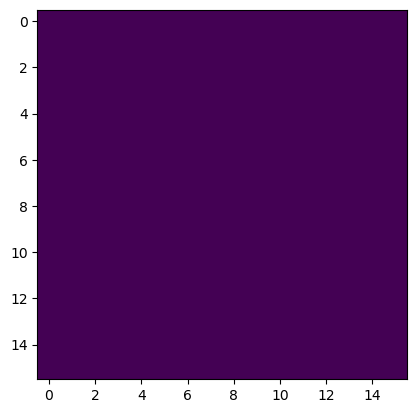

In [46]:
x_9 = x_pos[0,10,0,:,:]
x_9 = x_9.numpy()
x_9 = x_9.reshape((16,16))
plt.imshow(x_9)